In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt

movies = pd.read_csv('ml-latest-small/movies.csv')

ratings = pd.read_csv('ml-latest-small/ratings.csv')

tags = pd.read_csv('ml-latest-small/tags.csv')

In [2]:
import warnings
warnings.filterwarnings('ignore')

Raw Data inspection

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = ratings.drop('timestamp' , axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
tags = tags.drop('timestamp', axis=1)
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [6]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies by ', len(ratings['userId'].unique()), ' users.')

The dataset contains:  100836  ratings of  9742  movies by  610  users.


Dataset manipulation and creation of Datapoints for clustering


First I'll find the 3 most popular genres and tags among users to perform clustering and to visualize the results in a clearer way.
Then I will try using all different genres/tags and finally I will make use of Dimensionality reduction through PCA.
Eventually a comparision will be made for the three methods using different evaluation metrics in order to find the better clustering strategy for building a Movie recommender system.

In [7]:
# find 3 most rated genres
movie_genres = movies['genres'].apply(lambda x: x.split('|'))
genres = movie_genres.apply(pd.Series).stack().value_counts()
genres.head(3)

Drama       4361
Comedy      3756
Thriller    1894
Name: count, dtype: int64

In [8]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    genre_ratings = pd.concat([genre_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
#genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Adventure'], ['userId', 'Romance', 'Sci-Fi', 'Adventure'])
genre_ratings = get_genre_ratings(ratings, movies, ['Drama', 'Comedy', 'Thriller'], ['userId', 'Drama', 'Comedy', 'Thriller'])

genre_ratings.head()


,userId,Drama,Comedy,Thriller
0,1.0,NaN,NaN,NaN
1,2.0,4.53,4.28,4.15
2,3.0,3.88,4.00,3.70
3,4.0,0.75,1.00,4.14
4,5.0,3.48,3.51,3.55


In [9]:
# Remove missing values
genre_ratings = genre_ratings.dropna()

In [10]:
# find the most rated tags
tag_counts = tags['tag'].value_counts()
tag_counts.head(3)

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
Name: count, dtype: int64

In [11]:
def get_tag_ratings(ratings, tag_data, tags, column_names):
    #tag_data = tag_data.dropna()
    tag_ratings = pd.DataFrame()
    tag_ratings = pd.concat([tag_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for tag in tags:        
        tag_movies = tag_data[tag_data['tag'].str.contains(tag) ]
        avg_tag_votes_per_user = ratings[ratings['movieId'].isin(tag_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        tag_ratings = pd.concat([tag_ratings, avg_tag_votes_per_user], axis=1)
        
    tag_ratings.columns = column_names
    return tag_ratings

# Calculate the average rating of funny and fantasy movies
#tag_ratings = get_tag_ratings(ratings, tags, ['funny', 'fantasy', 'mafia'], ['userId', 'funny', 'fantasy', 'mafia'])
tag_ratings = get_tag_ratings(ratings, tags, ['In Netflix queue', 'atmospheric', 'thought-provoking'], ['userId', 'In Netflix queue', 'atmospheric', 'thought-provoking'])

tag_ratings.head()


,userId,In Netflix queue,atmospheric,thought-provoking
0,1.0,NaN,NaN,NaN
1,2.0,4.0,3.67,4.50
2,3.0,NaN,4.00,3.67
3,4.0,NaN,NaN,0.50
4,5.0,4.5,2.00,2.67


In [12]:
# Remove missing values
tag_ratings = tag_ratings.dropna()

Biasing dataset to obtain a more delimited subset of people

In [13]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    return genre_ratings[((genre_ratings['Drama'] < score_limit_1 - 0.2) & (genre_ratings['Comedy'] > score_limit_2)) | ((genre_ratings['Comedy'] < score_limit_1) & (genre_ratings['Drama'] > score_limit_2))]
# Bias the dataset
genre_ratings_biased = bias_genre_rating_dataset(genre_ratings, 3.5, 2.3)
genre_ratings_biased = genre_ratings_biased.reset_index(drop=True)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(genre_ratings_biased))

Number of records:  262


In [14]:
def bias_tag_rating_dataset(tag_ratings, score_limit_1, score_limit_2):
    return tag_ratings[((tag_ratings['atmospheric'] < score_limit_1 - 0.2) & (tag_ratings['In Netflix queue'] > score_limit_2)) | ((tag_ratings['In Netflix queue'] < score_limit_1) & (tag_ratings['atmospheric'] > score_limit_2))]
# Bias the dataset
tag_ratings_biased = bias_tag_rating_dataset(tag_ratings, 3.5, 2.3)
tag_ratings_biased = tag_ratings_biased.reset_index(drop=True)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(tag_ratings_biased))

Number of records:  53


Visualization of Data

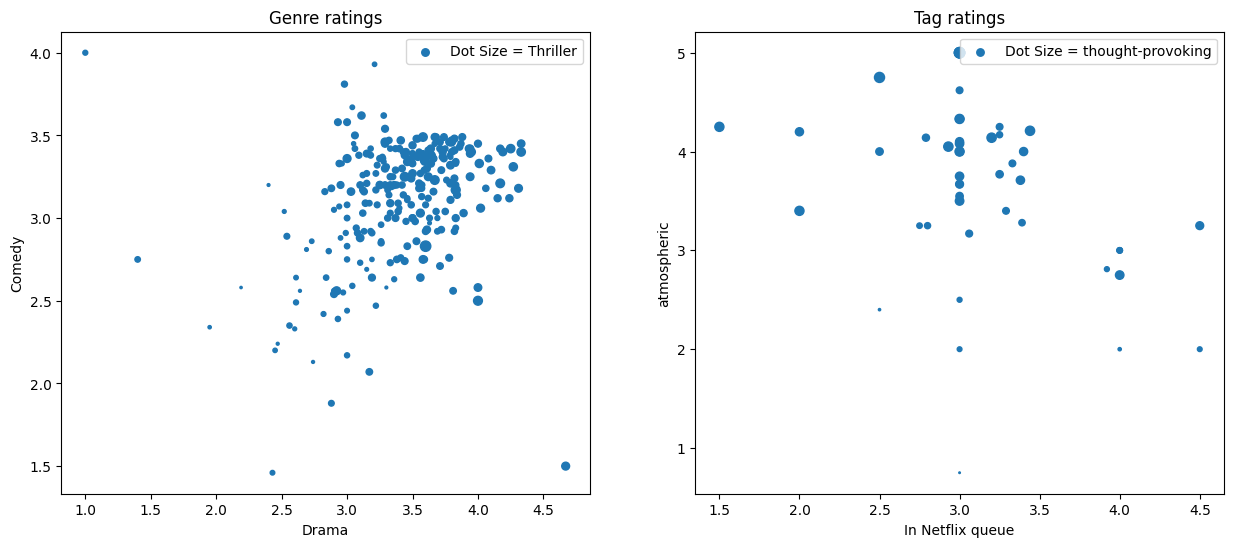

In [15]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(genre_ratings_biased['Drama'],genre_ratings_biased['Comedy'], s=genre_ratings_biased['Thriller']**2.5, label='Dot Size = Thriller')
ax.set_xlabel('Drama')
ax.set_ylabel('Comedy')
ax.set_title('Genre ratings')
ax.legend()

ax = fig.add_subplot(122)
ax.scatter(tag_ratings_biased['In Netflix queue'], tag_ratings_biased['atmospheric'], s=tag_ratings_biased['thought-provoking']**2.5, label = 'Dot Size = thought-provoking')
ax.set_xlabel('In Netflix queue')
ax.set_ylabel('atmospheric')
ax.set_title('Tag ratings')
ax.legend()


Training and test set separiation

In [16]:
#divide the data into training and test set by 80% and 20% respectively

movies_train = genre_ratings_biased.sample(frac=0.8, random_state=0)
movies_test = genre_ratings_biased.drop(movies_train.index)

tags_train = tag_ratings_biased.sample(frac=0.8, random_state=0)
tags_test = tag_ratings_biased.drop(tags_train.index)

Clustering

In [17]:
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, AffinityPropagation , MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


clustering_methods = [KMeans, Birch, MiniBatchKMeans, AffinityPropagation , 
                      MeanShift, AgglomerativeClustering, SpectralClustering] 

In [18]:
#create a function to plot the clusters in 3d and 2d with input the vector of predicted clusters for genres and tags respectively

def plot_clusters_3d(X, Y, predictions, genre_k, tag_k):
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X['Drama'],X['Comedy'],X['Thriller'], c=predictions[0].labels_, cmap='tab10')
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_zlabel('Adventure')
    ax.set_title('Clusters by favourite genres with K = ' + str(genre_k))

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], Y['thought-provoking'], c=predictions[1].labels_, cmap='tab10')
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_zlabel('Mafia')
    ax.set_title('Clusters by favourite tags with K = ' + str(tag_k))

    plt.show()
'''
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121)
    ax.scatter(X['Drama'],X['Comedy'],c=predictions[0].labels_, cmap='tab10', s=X['Thriller']**3)
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_title('Genre clustering, K = ' + str(genre_k) + ' (size = Adventure)')

    ax = fig.add_subplot(122)
    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], c=predictions[1].labels_, cmap='tab10', s=Y['thought-provoking']**3)
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_title('Tag clustering, K = ' + str(tag_k) + ' (size = Mafia)')

    plt.show()
    '''

"\n    fig = plt.figure(figsize=(15,6))\n    ax = fig.add_subplot(121)\n    ax.scatter(X['Drama'],X['Comedy'],c=predictions[0].labels_, cmap='tab10', s=X['Thriller']**3)\n    ax.set_xlabel('Sci-Fi')\n    ax.set_ylabel('Romance')\n    ax.set_title('Genre clustering, K = ' + str(genre_k) + ' (size = Adventure)')\n\n    ax = fig.add_subplot(122)\n    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], c=predictions[1].labels_, cmap='tab10', s=Y['thought-provoking']**3)\n    ax.set_xlabel('Funny')\n    ax.set_ylabel('Fantasy')\n    ax.set_title('Tag clustering, K = ' + str(tag_k) + ' (size = Mafia)')\n\n    plt.show()\n    "

In [19]:
def Cluster_data(data, n_clusters, cluster_function):
    X = data.copy()
    X = X.drop('userId', axis=1)
    if(cluster_function in [MeanShift, AffinityPropagation, SpectralClustering]):
        cluster = cluster_function()
    else:
        cluster = cluster_function(n_clusters=n_clusters)
    predictions = cluster.fit_predict(X)
    return cluster

In [20]:
#function to plot silhouette score for different number of clusters and different clustering methods
def silhouette_score_plot(data, method, title):
    trials = 1

    mean_genre_score = []
    for trial in range(trials):
        genre_score = []
        for i in range(2, 20):
            X = data[0].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            genre_score.append(silhouette_score(X, labels))
        mean_genre_score.append(genre_score)

    mean_genre_score = np.mean(mean_genre_score, axis=0)    

    best_genre_K = np.argmax(mean_genre_score) + 2
    if best_genre_K == 2:
        best_genre_K = 3

    mean_tag_score = []
    for trial in range(trials):
        tag_score = []    
        for i in range(2, 20):
            X = data[1].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            #compute silhouette score for tags
            tag_score.append(silhouette_score(X, labels))
        mean_tag_score.append(tag_score)

    mean_tag_score = np.mean(mean_tag_score, axis=0)     

    best_tag_K = np.argmax(mean_tag_score) + 2
    if best_tag_K == 2:
        best_tag_K = 3

    #plot silhouette score
    _ , ax = plt.subplots(ncols=2, nrows=1, figsize=(15,3))

    ax[0].plot(range(2, 20), mean_genre_score)
    ax[0].set_title('Silhouette score for genres')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Silhouette score')
    ax[0].grid()
    ax[1].plot(range(2, 20), mean_tag_score)
    ax[1].set_title('Silhouette score for tags')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette score')
    ax[1].grid()
    plt.suptitle(title)
    plt.show()

    return best_genre_K, best_tag_K

For algorithms that requires to select the numebr of clusters, I plotted the silhouette score for some values of K to choose the best number of clusters, the higher the better.

KMeans Clustering algorithm                                                            

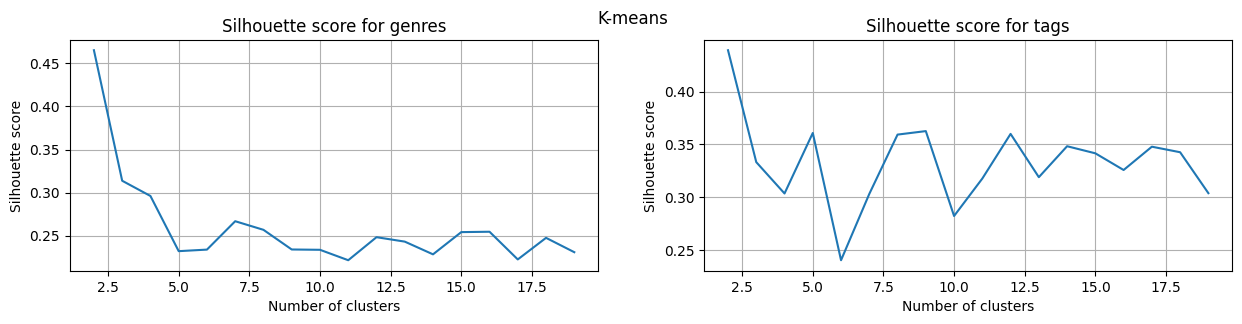

In [21]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], KMeans,'K-means')

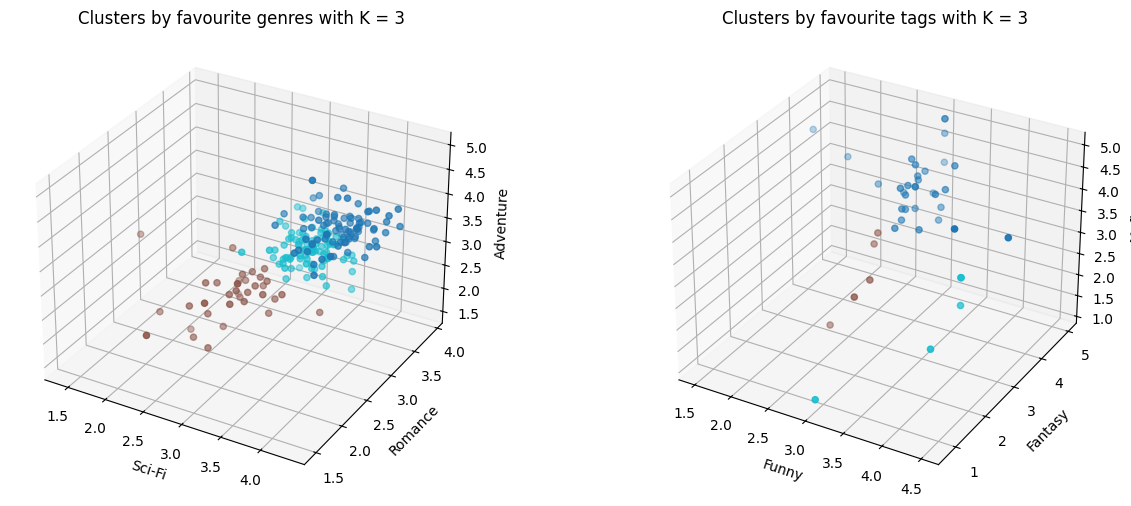

In [22]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(movies_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(tags_train, tag_K, KMeans)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_kmean,tag_model_kmean], genre_k, tag_K)


Birch Clustering Algorithm

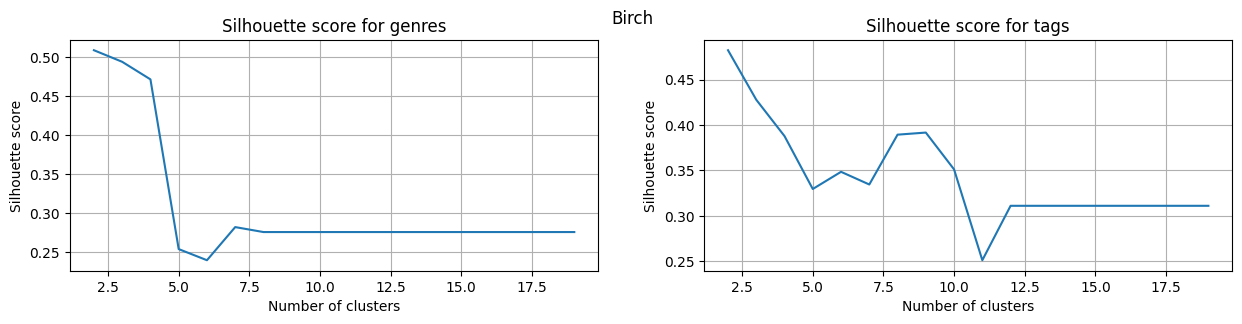

In [23]:
#optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], Birch,'Birch')

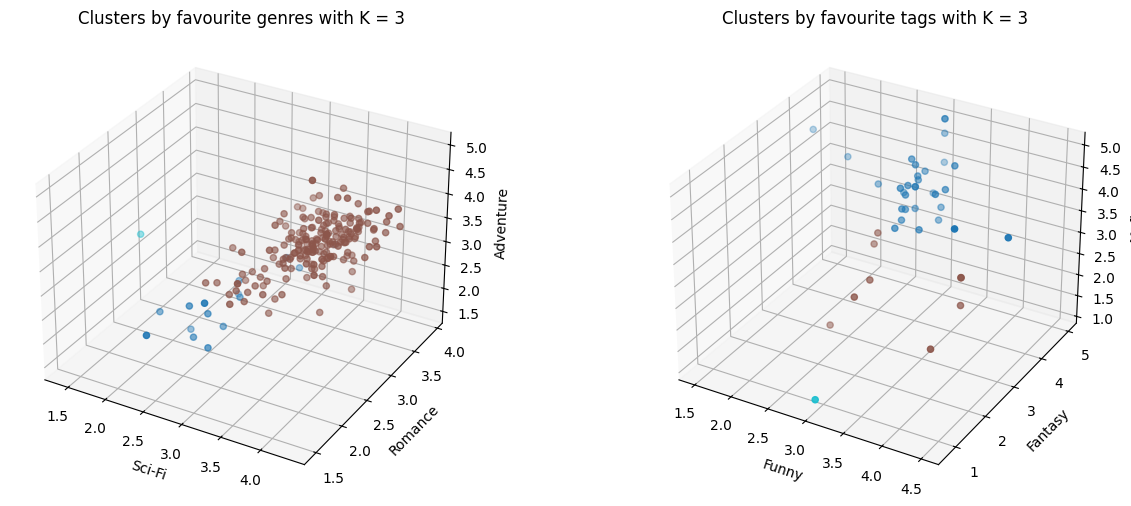

In [24]:
#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(movies_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(tags_train, tag_K, Birch)


#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_birch,tag_model_birch],genre_k, tag_K)

Mini-Batch K-Means Clustering

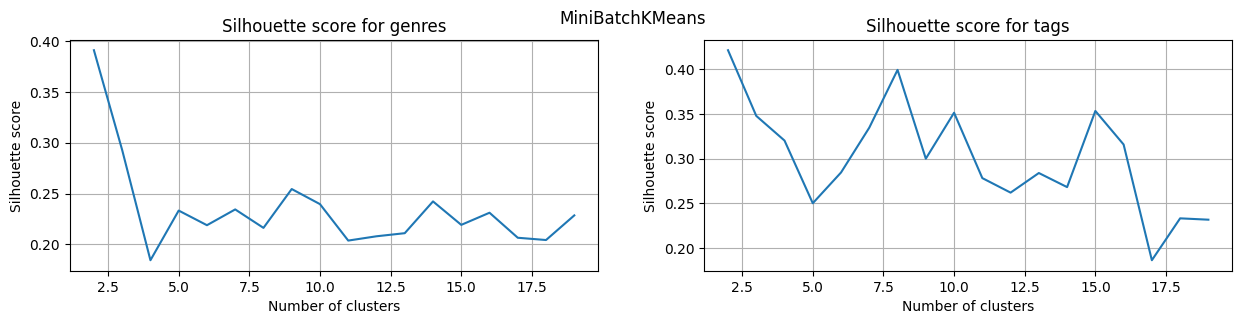

In [25]:
#optimization of K for Minibatch KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], MiniBatchKMeans,'MiniBatchKMeans')

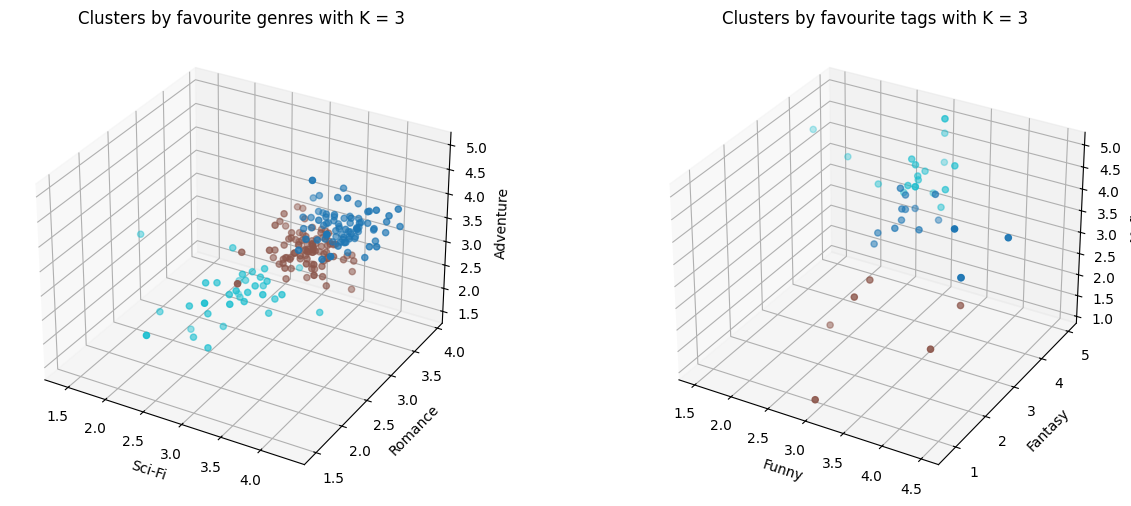

In [26]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(movies_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(tags_train, tag_K, MiniBatchKMeans)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_minibatcheskmeans,tag_model_minibatcheskmeans],genre_k, tag_K)

Mean-Shift Clustering

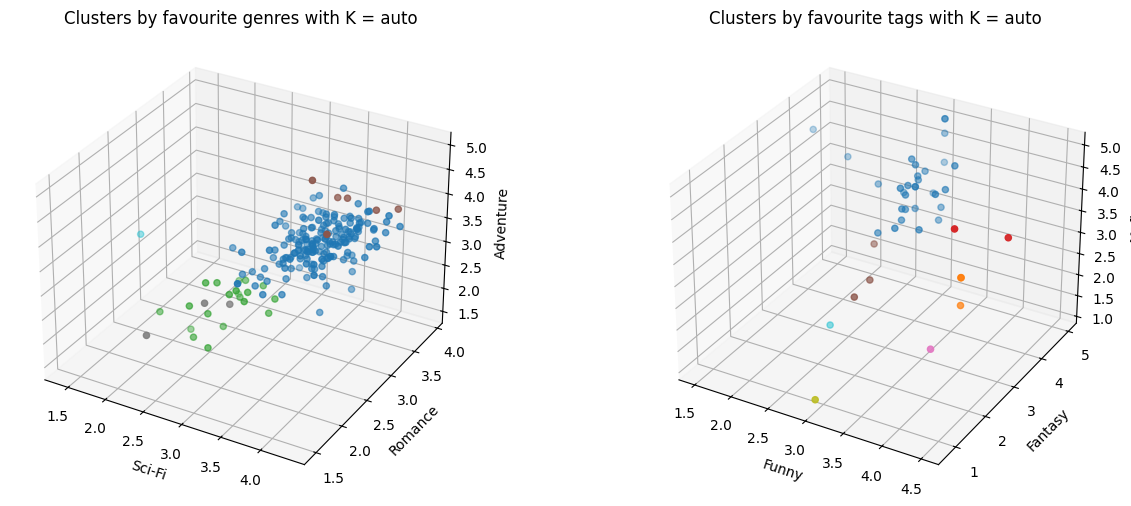

In [27]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(movies_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(tags_train, 3, MeanShift)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_meanshift,tag_model_meanshift], 'auto' , 'auto')

Affinity Propagation Clustering

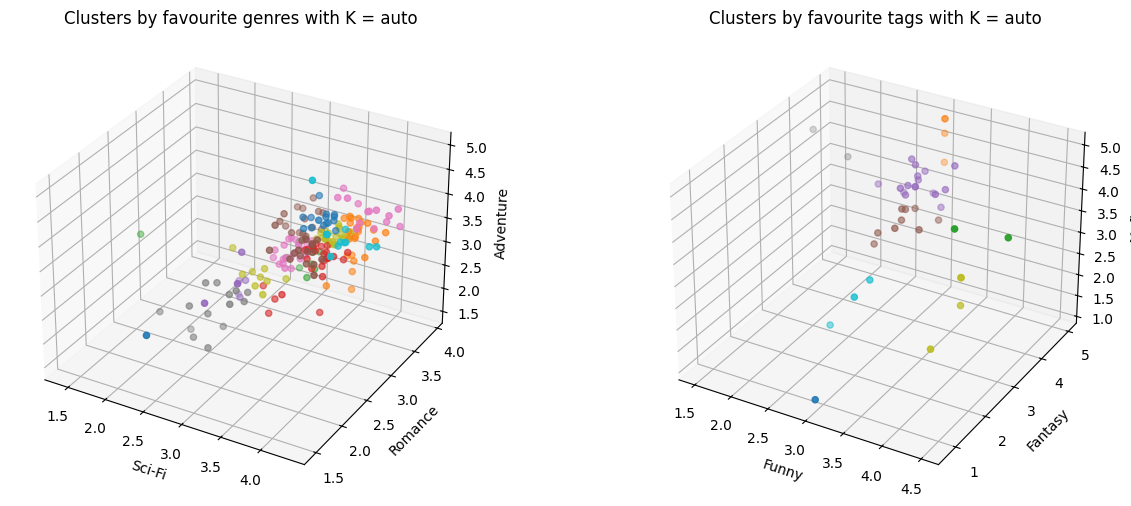

In [28]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(movies_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(tags_train, 7, AffinityPropagation)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_affinity,tag_model_affinity], 'auto' , 'auto')

Agglomerative Clustering

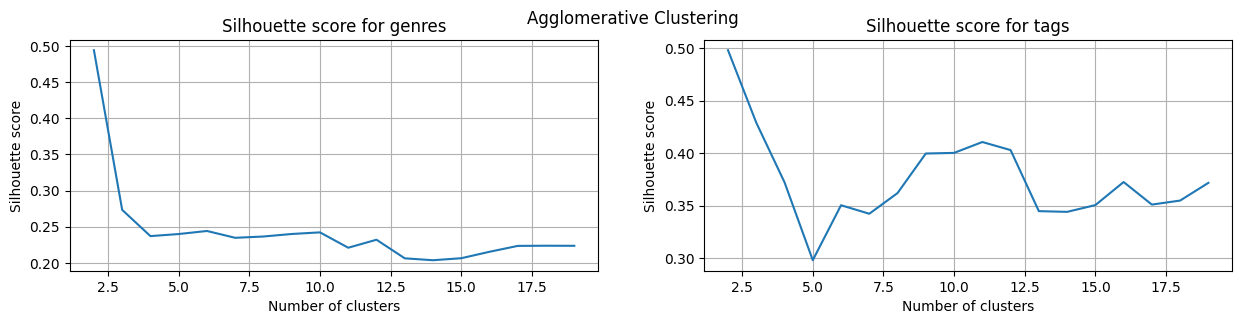

In [29]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], AgglomerativeClustering,'Agglomerative Clustering')

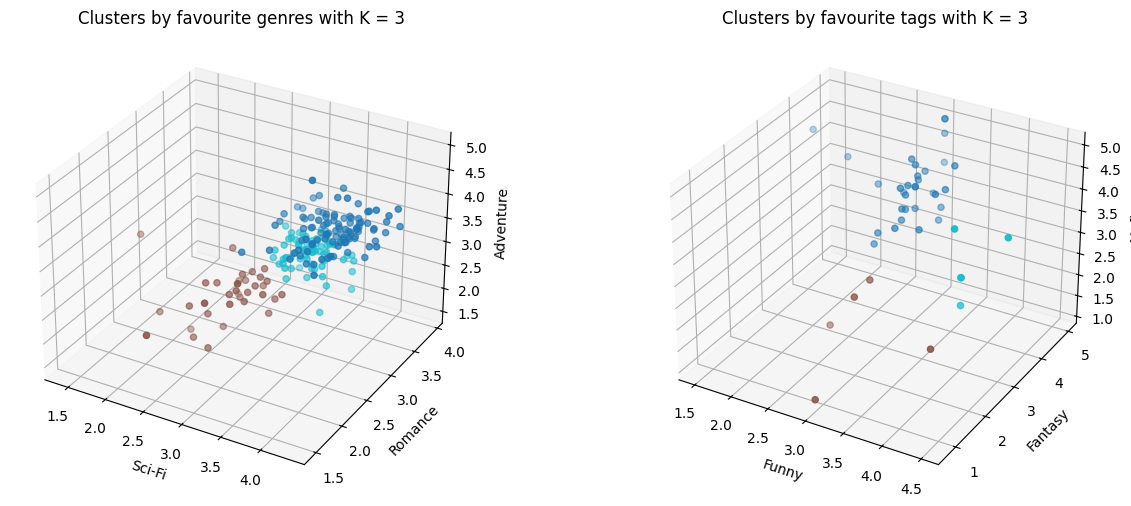

In [30]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(movies_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(tags_train, tag_K, AgglomerativeClustering)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_agglomerative,tag_model_agglomerative], genre_k, tag_K)

Spectral Clustering

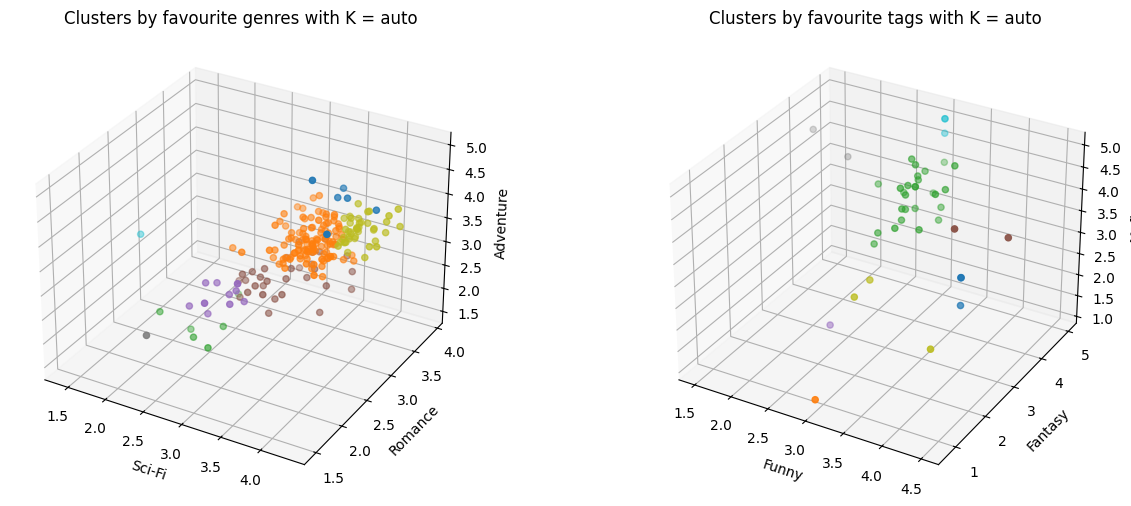

In [31]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(movies_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(tags_train, 3, SpectralClustering)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_spectral,tag_model_spectral], 'auto', 'auto')

Evaluation of performance for the 7 clustering models

In [32]:
# I used the mean of each cluster datapoints as centroids to have uniformity 
# between different models since some of them doesn't come with the centroids attribute 

def get_centroids(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    for i in range(number_of_clusters):
        cluster = data[predictions == i]
        cluster = cluster.drop('userId', axis=1)
        cluster = cluster.mean()
        centroids.append(cluster.values)            
    return centroids

In [33]:
# function to predic new data_points clusters for agglomerative 
# and spectral clustering which do not have a proper prediction method
def pseudo_predict_new_data(test_data, train_data, model):
    predictions = []
    for index, row in test_data.iterrows():
        min_distance = float('inf')
        cluster_id = -1
        for i in range(len(set(model.labels_))):
            distance = np.linalg.norm(row[1:] - get_centroids(train_data,model)[i])
            if distance < min_distance:
                min_distance = distance
                cluster_id = i
        predictions.append(model.labels_[cluster_id])
    return predictions

In [34]:
#Function to predict new data points from testset into existing models
def predict_new_data(test_data, model,train_data, model_name):
    X = test_data.copy()
    X = X.drop('userId', axis=1)
    if(model_name in['Agglomerative', 'Spectral']):
        predictions = pseudo_predict_new_data(test_data, train_data, model)
    else:
        predictions = model.predict(X)
    return predictions

In [35]:
def plot_results(model_names, genre_criteria, tag_criteria, max_index, title, y_label):

    color = (0.1, 0.2, 0.5, 0.3)
    highest_bar_color = 'green'
    fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(15,5))
    ax[0].bar(model_names, genre_criteria, color = color)
    #ax[0].set_xlabel('Clustering Models')
    ax[0].set_ylabel(y_label)
    ax[0].set_title(f'{title} genre')
    ax[0].set_xticklabels(model_names, rotation=45)
    bars = ax[0].get_children() 
    bars[max_index[0]].set_color(highest_bar_color)

    ax[1].bar(model_names, tag_criteria, color = color)
    #ax[1].set_xlabel('Clustering Models')
    ax[1].set_ylabel(y_label)
    ax[1].set_title(f'{title} tag')
    ax[1].set_xticklabels(model_names, rotation=45)
    bars = ax[1].get_children() 
    bars[max_index[1]].set_color(highest_bar_color)

    plt.show()

MEAN SQUARED ERROR

In [36]:
#function to calculate MSE for different clustering models
def calculate_MSE(test_data, model,train_data, model_name):
    new_predictions = predict_new_data(test_data, model,train_data, model_name)
    #new_predictions = model.labels_
    Mse = 0
    centroids = get_centroids(train_data, model)
    test_data = test_data.reset_index()
    for index, row in test_data.iterrows():
        user = row.drop('userId')
        user = user.drop('index')
        user = user.values
        cluster_id = list(set(model.labels_)).index(new_predictions[index])
        Mse += np.square(np.linalg.norm((user - centroids[cluster_id])))
    return Mse/len(test_data)


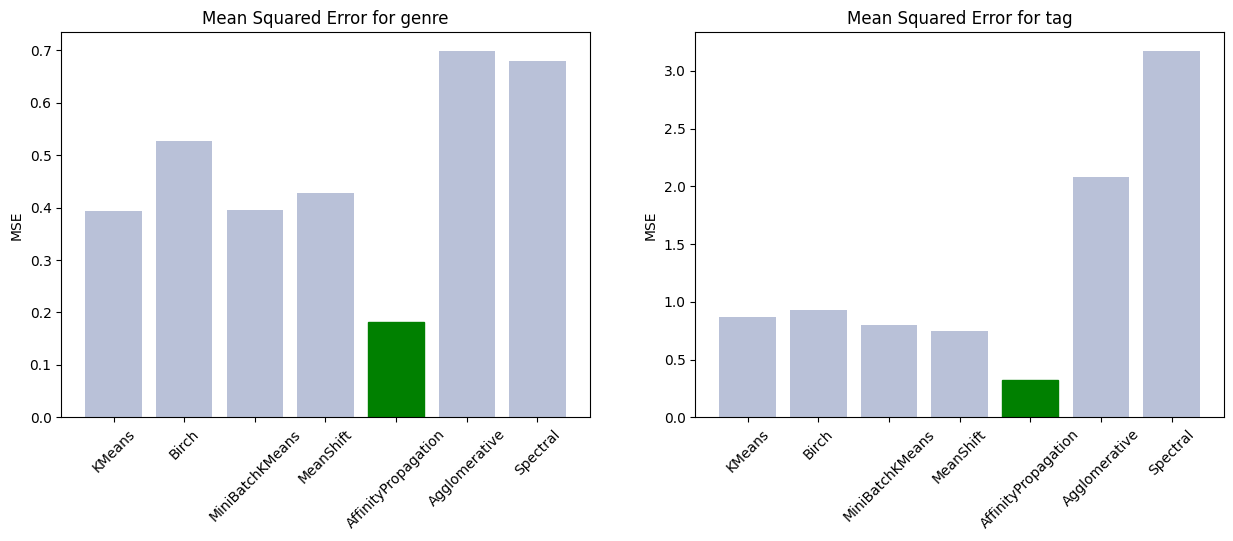

In [37]:
#plot the MSE for different clustering models
genre_models = [genre_model_kmean, genre_model_birch, genre_model_minibatcheskmeans, genre_model_meanshift, genre_model_affinity, genre_model_agglomerative, genre_model_spectral]
tag_models = [tag_model_kmean, tag_model_birch, tag_model_minibatcheskmeans, tag_model_meanshift, tag_model_affinity, tag_model_agglomerative, tag_model_spectral]
model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

genre_MSE = []
for i in range(len(genre_models)):
    genre_MSE.append(calculate_MSE(movies_test, genre_models[i], movies_train, model_names[i]))
best_genre = genre_MSE.index(min(genre_MSE))

tag_MSE = []
for i in range(len(tag_models)):
    tag_MSE.append(calculate_MSE(tags_test, tag_models[i], tags_train, model_names[i]))
best_tag = tag_MSE.index(min(tag_MSE))


plot_results(model_names, genre_MSE, tag_MSE, [best_genre, best_tag], 'Mean Squared Error for', 'MSE')

DUNN'S INDEX

In [38]:
#a function to calculate the Dunn index for different existing clustering models
def calculate_Dunn_index(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    centroids = get_centroids(data, model)
    min_distance = float('inf')
    for i in range(number_of_clusters):
        for j in range(i+1, number_of_clusters):
            distance = np.linalg.norm(centroids[i] - centroids[j])
            if distance < min_distance:
                min_distance = distance
    max_distance = 0
    for i in range(number_of_clusters):
        for j in range(len(data)):
            if predictions[j] == i:
                distance = np.linalg.norm(data.iloc[j].drop('userId').values - centroids[i])
                if distance > max_distance:
                    max_distance = distance
    return min_distance/max_distance

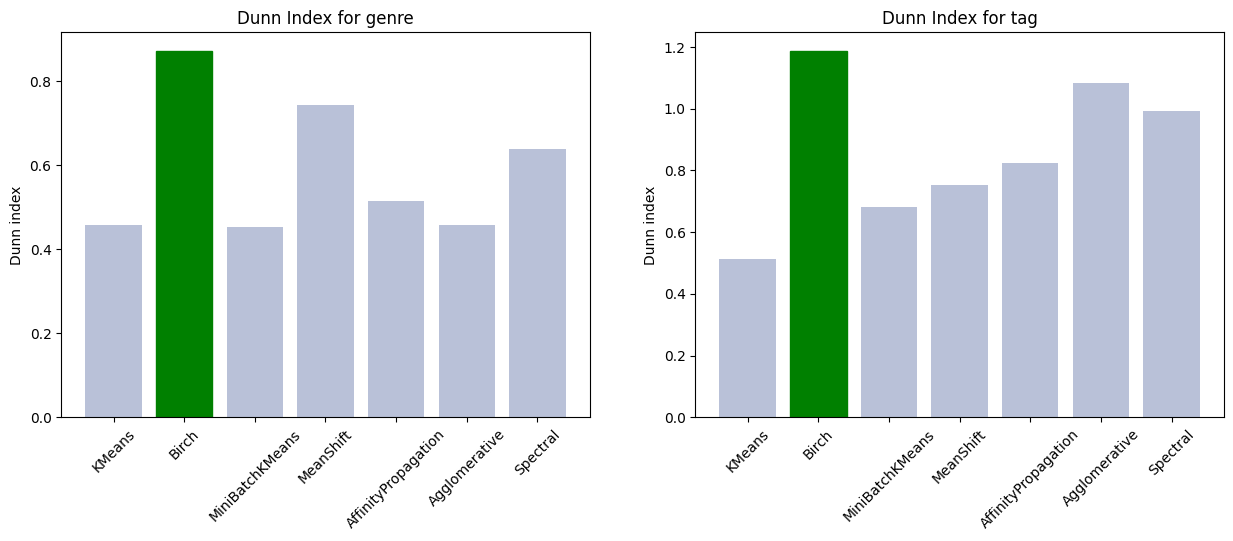

In [39]:
genre_Dunn = []
for i in range(len(genre_models)):
    genre_Dunn.append(calculate_Dunn_index(movies_train, genre_models[i]))
best_genre = genre_Dunn.index(max(genre_Dunn))

tag_Dunn = []
for i in range(len(tag_models)):
    tag_Dunn.append(calculate_Dunn_index(tags_train, tag_models[i]))
best_tag = tag_Dunn.index(max(tag_Dunn))

plot_results(model_names, genre_Dunn, tag_Dunn, [best_genre, best_tag], 'Dunn Index for', 'Dunn index')

AVARAGE SIMILARITY

In [149]:
def cosine_similarity(v1, v2):
  v1_norm = np.linalg.norm(v1)
  v2_norm = np.linalg.norm(v2)
  if v1_norm * v2_norm == 0:
    return 0
  return np.abs(np.dot(v1, v2)) / (v1_norm * v2_norm)


In [151]:
def average_similarity_between_clusters(data, cluster_labels, cluster1, cluster2):

  cluster1_data = data[cluster_labels == cluster1]
  cluster2_data = data[cluster_labels == cluster2]


  similarities = []
  for data1 in cluster1_data:
    for data2 in cluster2_data:
      similarities.append(cosine_similarity(data1, data2))

  if not similarities:
    return 0

  return np.mean(similarities)


In [152]:
 #compute the average similarity between clusters for every pair of clusters and then avarage them
def average_similarity(data, model):
  cluster_similarities = []
  labels = model.labels_
  for cluster1 in range(len(set(labels))):
    for cluster2 in range(cluster1+1, len(set(labels))):
      if cluster1 != cluster2:
        cluster_similarities.append(average_similarity_between_clusters(data, labels, cluster1, cluster2))
  return np.mean(cluster_similarities)

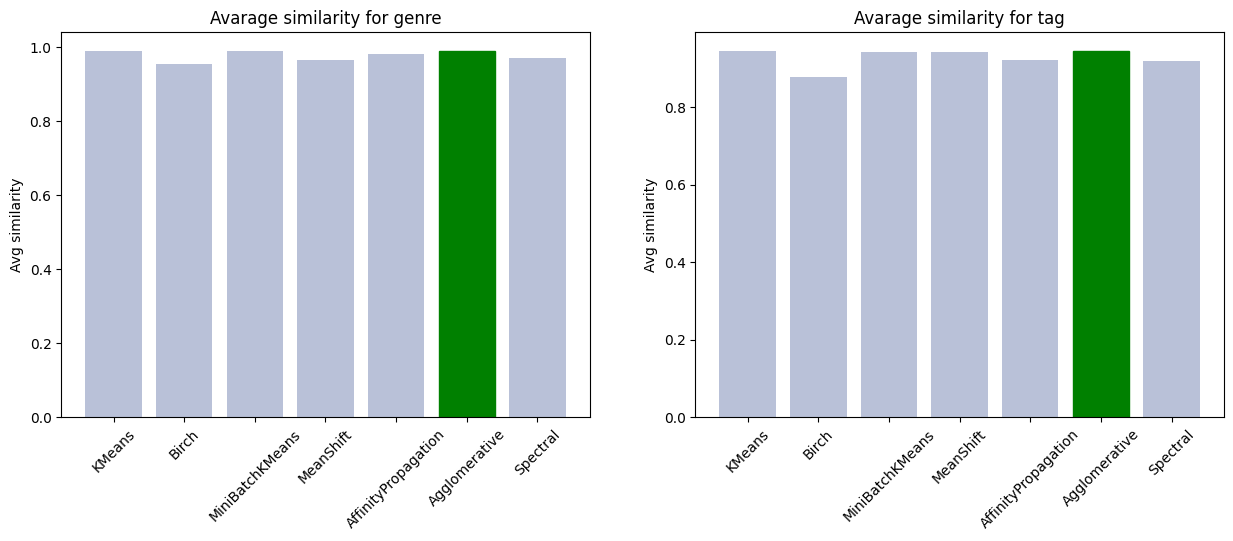

In [43]:
genre_similarities = []
for i in range(len(genre_models)):
    genre_similarities.append(average_similarity(movies_train.drop('userId', axis=1).values, genre_models[i]))
best_genre = genre_similarities.index(max(genre_similarities))

tag_similarities = []
for i in range(len(tag_models)):
    tag_similarities.append(average_similarity(tags_train.drop('userId', axis= 1).values, tag_models[i]))
best_tag = tag_similarities.index(max(tag_similarities))

plot_results(model_names, genre_similarities, tag_similarities, [best_genre, best_tag], 'Avarage similarity for', 'Avg similarity')

COMPUTATIONAL TIME

In [44]:
def evaluate_models(data, clustering_methods):
    results = []
    for method in clustering_methods:
        start = time.time()
        Cluster_data(data, 3, method)
        end = time.time()
        results.append((end-start)*1000)
    return results

genre_results = evaluate_models(movies_train, clustering_methods)
best_genre = genre_results.index(min(genre_results))
tag_results = evaluate_models(tags_train, clustering_methods)
best_tag = tag_results.index(min(tag_results))

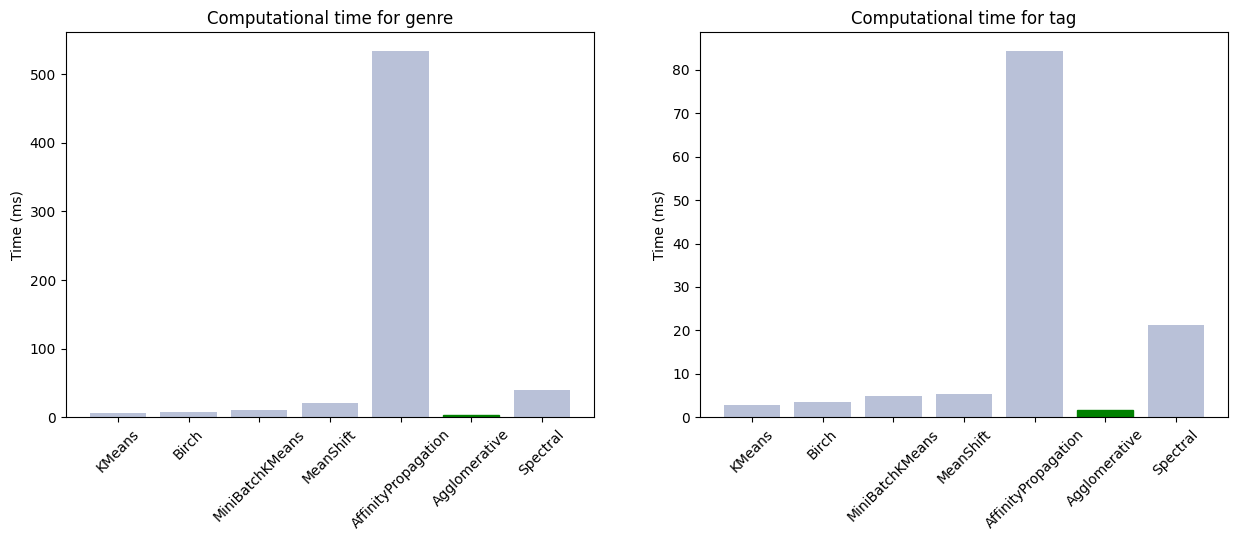

In [45]:
plot_results(model_names, genre_results, tag_results, [best_genre, best_tag], 'Computational time for', 'Time (ms)')

OTHER CRITERIA!!!!!!!!!!!!!!!!!!!!

scelgo numero di k per avere top_n_movies!!!!!!!
printo userId del test set da testare per le recommendations

In [46]:
#Function that returns the top N recommended movies for a given user 
def TOP_N_MOVIES_GENRE(train_set, test_set, model,user_id,N, model_name):
    if(user_id in test_set['userId'].values):
        X = test_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(test_set, model, train_set, model_name)[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == test_set.iloc[new_user]['userId']]
    elif(user_id in train_set['userId'].values):
        X = train_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == train_set.iloc[new_user]['userId']]
    else:
        print('User not found')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1)

TOP_N_MOVIES_GENRE(movies_train, movies_test, genre_model_birch, 609, 20, 'birch')

,title
movieId,
91355,Asterix and the Vikings (Astérix et les Viking...
4334,Yi Yi (2000)
96935,My Left Eye Sees Ghosts (Ngo joh aan gin diy g...
7121,Adam's Rib (1949)
117192,Doctor Who: The Time of the Doctor (2013)
142444,The Editor (2015)
98279,"Fantastic Fear of Everything, A (2012)"
7096,Rivers and Tides (2001)
85295,Scooby-Doo! Curse of the Lake Monster (2010)


In [47]:
#do the same for tags clustering

def TOP_N_MOVIES_TAGS(train_set, test_set, model,user_id,N, model_name):
    if(user_id in test_set['userId'].values):
        X = test_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(test_set, model, train_set, model_name)[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == test_set.iloc[new_user]['userId']]
    elif(user_id in train_set['userId'].values):
        X = train_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == train_set.iloc[new_user]['userId']]
    else:
        print('User not found')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1)

TOP_N_MOVIES_TAGS(tags_train, tags_test, tag_model_birch, 5, 20, 'birch')

,title
movieId,
4327,"Magnificent Seven, The (1960)"
4225,"Dish, The (2001)"
1957,Chariots of Fire (1981)
66934,Dr. Horrible's Sing-Along Blog (2008)
8638,Before Sunset (2004)
4535,"Man from Snowy River, The (1982)"
4454,More (1998)
4356,Gentlemen Prefer Blondes (1953)
68954,Up (2009)


Now I will perform clustering of the dataset exploiting all the available dimensions by considering all 20 genres in my analysis

Parallel to that, I will consider just the 20 most popular tags to avoid the "Curse of Dimensionality" that would certainly affect the study by considering all the 1589 different tags.

In [76]:
#find 20 most popular tags
tag_counts = tags['tag'].value_counts()
tag_counts = tag_counts.head(20)
tag_counts

tag
In Netflix queue      131
atmospheric            36
thought-provoking      24
superhero              24
funny                  23
surreal                23
Disney                 23
religion               22
sci-fi                 21
quirky                 21
dark comedy            21
psychology             21
suspense               20
twist ending           19
visually appealing     19
crime                  19
politics               18
mental illness         16
music                  16
time travel            16
Name: count, dtype: int64

In [77]:
#get a list of all genres
all_genres = []
for genre in movies['genres']:
    all_genres.extend(genre.split('|'))
all_genres = list(set(all_genres))

column_names_genre = all_genres.copy()
column_names_genre.insert(0, 'userId')

In [78]:
#get a list of 20 most popular tags
all_tags = list(tag_counts.index)

column_names_tags = all_tags.copy()
column_names_tags.insert(0, 'userId')

In [182]:
all_genre_ratings = get_genre_ratings(ratings, movies, all_genres, column_names_genre)
all_genre_ratings.head()

,userId,Animation,Action,IMAX,Musical,Mystery,(no genres listed),Drama,Film-Noir,Adventure,...,Crime,Fantasy,Western,Sci-Fi,Horror,War,Comedy,Documentary,Thriller,Children
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,4.69,4.32,NaN,4.68,4.17,NaN,4.53,5.0,4.39,...,4.36,4.30,4.29,4.22,3.47,4.50,4.28,NaN,4.15,4.55
2,3.0,NaN,3.95,3.75,NaN,4.00,NaN,3.88,NaN,4.17,...,3.80,NaN,3.50,3.88,3.00,4.50,4.00,4.33,3.70,NaN
3,4.0,0.50,3.57,NaN,0.50,5.00,NaN,0.75,NaN,2.73,...,0.50,3.38,NaN,4.20,4.69,0.50,1.00,NaN,4.14,0.50
4,5.0,4.00,3.32,3.00,4.00,3.48,NaN,3.48,4.0,3.66,...,3.81,3.68,3.80,2.83,4.25,3.57,3.51,4.00,3.55,3.80


In [191]:
# compute the avarage rating of each user
user_means = all_genre_ratings.drop('userId', axis=1).mean(axis=1)

#for every row, fill the empty values with the mean of that row
for row in range(len(all_genre_ratings)):
    for column in range(1, len(all_genre_ratings.columns)):
        if pd.isnull(all_genre_ratings.iloc[row, column]):
            all_genre_ratings.iloc[row, column] = user_means[row]
all_genre_ratings = all_genre_ratings.dropna()

,userId,Animation,Action,IMAX,Musical,Mystery,(no genres listed),Drama,Film-Noir,Adventure,...,Crime,Fantasy,Western,Sci-Fi,Horror,War,Comedy,Documentary,Thriller,Children
1,2.0,4.690000,4.32,4.365294,4.680000,4.17000,4.365294,4.53,5.000000,4.39,...,4.36,4.300000,4.290,4.22,3.47,4.50,4.28,4.365294,4.15,4.550000
2,3.0,3.925714,3.95,3.750000,3.925714,4.00000,3.925714,3.88,3.925714,4.17,...,3.80,3.925714,3.500,3.88,3.00,4.50,4.00,4.330000,3.70,3.925714
3,4.0,0.500000,3.57,2.164000,0.500000,5.00000,2.164000,0.75,2.164000,2.73,...,0.50,3.380000,2.164,4.20,4.69,0.50,1.00,2.164000,4.14,0.500000
4,5.0,4.000000,3.32,3.000000,4.000000,3.48000,3.637895,3.48,4.000000,3.66,...,3.81,3.680000,3.800,2.83,4.25,3.57,3.51,4.000000,3.55,3.800000
5,6.0,4.330000,3.11,3.670000,4.400000,4.00000,3.564118,3.80,3.564118,3.25,...,3.83,4.140000,3.000,2.50,3.00,3.33,3.47,3.564118,3.56,4.110000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606.0,2.940000,3.22,3.680000,3.080000,3.44000,3.162778,3.12,3.162778,3.26,...,3.05,3.150000,3.330,3.29,2.87,2.78,3.26,3.000000,2.92,3.210000
606,607.0,3.710000,3.18,3.060000,3.730000,3.79000,3.580000,3.79,3.810000,3.50,...,3.65,3.600000,3.410,3.56,3.35,3.79,3.57,3.800000,3.53,3.450000
607,608.0,3.330000,3.72,5.000000,3.600000,4.65000,3.827647,4.01,3.827647,3.47,...,3.81,3.570000,4.000,3.25,4.11,4.17,3.33,3.827647,4.11,3.420000
608,609.0,3.120000,3.33,4.000000,2.760000,3.55000,3.223684,3.44,3.750000,3.22,...,3.61,3.000000,2.640,3.30,3.32,3.58,2.74,3.000000,3.54,2.460000


In [185]:
all_tags_ratings = get_tag_ratings(ratings, tags, all_tags, column__names_tags)
all_tags_ratings.head()

,userId,In Netflix queue,atmospheric,thought-provoking,superhero,funny,surreal,Disney,religion,sci-fi,...,dark comedy,psychology,suspense,twist ending,visually appealing,crime,politics,mental illness,music,time travel
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,4.0,3.67,4.50,4.2,4.00,5.0,4.62,5.0,4.75,...,4.6,3.00,3.29,4.67,NaN,4.5,5.0,5.0,4.0,4.33
2,3.0,NaN,4.00,3.67,4.0,3.83,4.0,NaN,NaN,3.50,...,3.0,4.25,4.00,4.00,4.0,4.5,5.0,NaN,4.0,NaN
3,4.0,NaN,NaN,0.50,NaN,NaN,NaN,0.50,NaN,NaN,...,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN
4,5.0,4.5,2.00,2.67,NaN,2.50,2.0,4.20,4.5,3.67,...,3.0,3.40,3.50,2.57,3.0,2.8,4.0,2.0,3.5,2.00


In [189]:
# compute the avarage rating of each user
user_means = all_tags_ratings.drop('userId', axis=1).mean(axis=1)

#for every row, fill the empty values with the mean of that row
for row in range(len(all_tags_ratings)):
    for column in range(1, len(all_tags_ratings.columns)):
        if pd.isnull(all_tags_ratings.iloc[row, column]):
            all_tags_ratings.iloc[row, column] = user_means[row]
all_tags_ratings = all_tags_ratings.dropna()

Training and test set separation

In [192]:
#divide the data into training and test set by 80% and 20% respectively
all_genre_ratings_train = all_genre_ratings.sample(frac=0.8, random_state=0)
all_genre_ratings_test = all_genre_ratings.drop(all_genre_ratings_train.index)

all_tags_ratings_train = all_tags_ratings.sample(frac=0.8, random_state=0)
all_tags_ratings_test = all_tags_ratings.drop(all_tags_ratings_train.index)

Clustering with 20 movie features

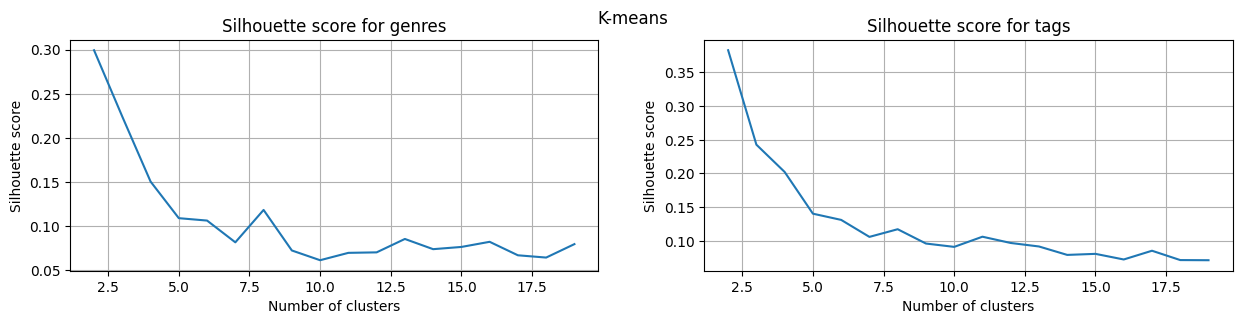

In [193]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], KMeans,'K-means')

In [194]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(all_genre_ratings_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(all_tags_ratings_train, tag_K, KMeans)

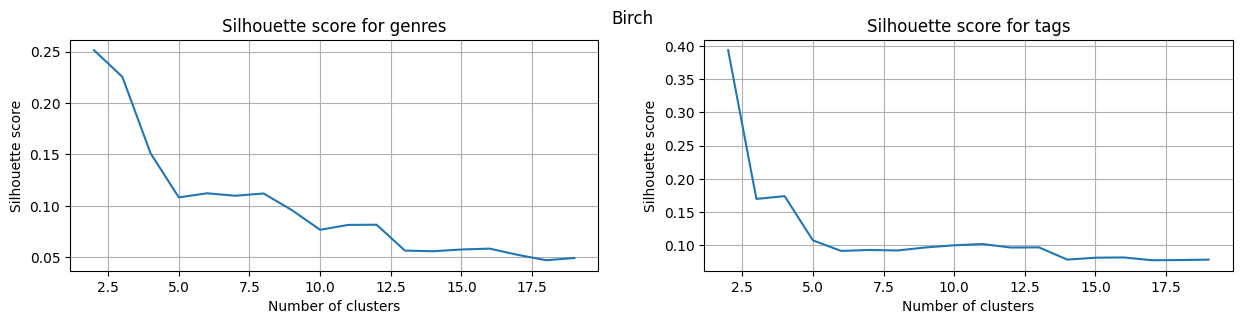

In [195]:
#Optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], Birch,'Birch')

In [196]:
#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(all_genre_ratings_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(all_tags_ratings_train, tag_K, Birch)

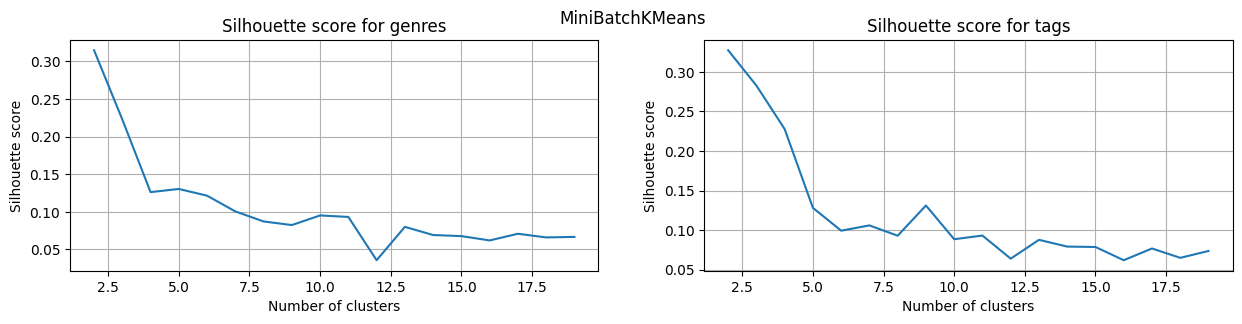

In [197]:
#Optimization of K for MiniBatchKMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], MiniBatchKMeans,'MiniBatchKMeans')

In [198]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(all_genre_ratings_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(all_tags_ratings_train, tag_K, MiniBatchKMeans)

In [199]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(all_genre_ratings_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(all_tags_ratings_train, 3, MeanShift)

In [200]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(all_genre_ratings_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(all_tags_ratings_train, 7, AffinityPropagation)

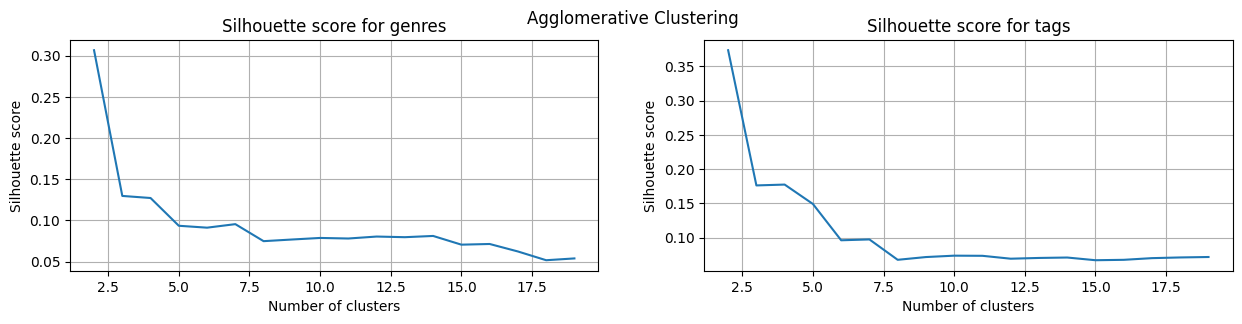

In [201]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], AgglomerativeClustering,'Agglomerative Clustering')

In [202]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(all_genre_ratings_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(all_tags_ratings_train, tag_K, AgglomerativeClustering)

In [203]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(all_genre_ratings_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(all_tags_ratings_train, 3, SpectralClustering)

Model evaluation

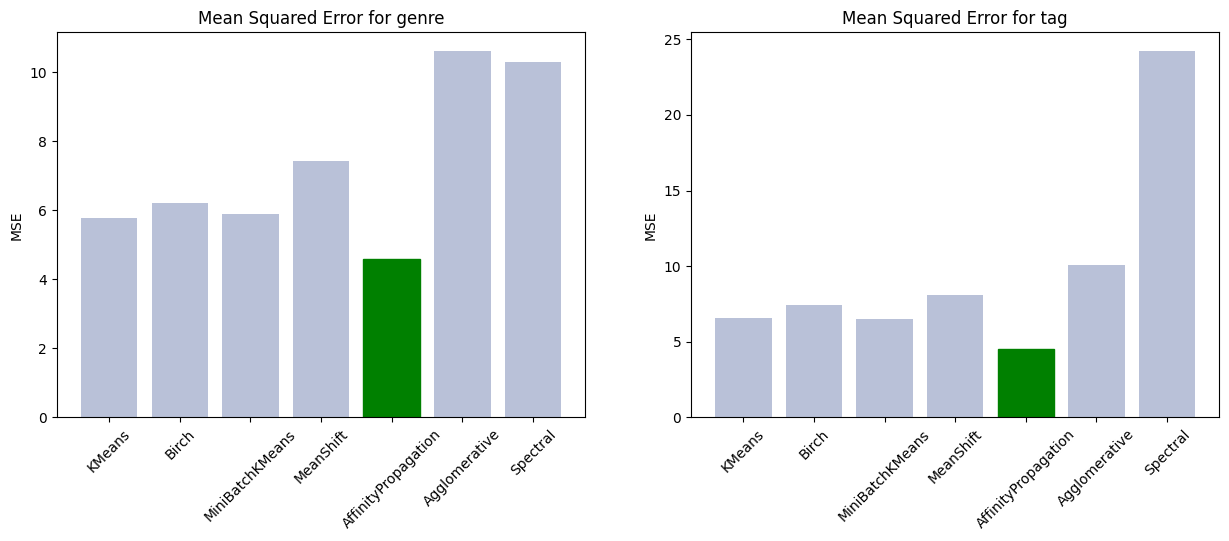

In [204]:
#plot the MSE for different clustering models
genre_models = [genre_model_kmean, genre_model_birch, genre_model_minibatcheskmeans, genre_model_meanshift, genre_model_affinity, genre_model_agglomerative, genre_model_spectral]
tag_models = [tag_model_kmean, tag_model_birch, tag_model_minibatcheskmeans, tag_model_meanshift, tag_model_affinity, tag_model_agglomerative, tag_model_spectral]
model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

genre_MSE = []
for i in range(len(genre_models)):
    genre_MSE.append(calculate_MSE(all_genre_ratings_test, genre_models[i], all_genre_ratings_train, model_names[i]))
best_genre = genre_MSE.index(min(genre_MSE))

tag_MSE = []
for i in range(len(tag_models)):
    tag_MSE.append(calculate_MSE(all_tags_ratings_test, tag_models[i], all_tags_ratings_train, model_names[i]))
best_tag = tag_MSE.index(min(tag_MSE))

plot_results(model_names, genre_MSE, tag_MSE, [best_genre, best_tag], 'Mean Squared Error for', 'MSE')

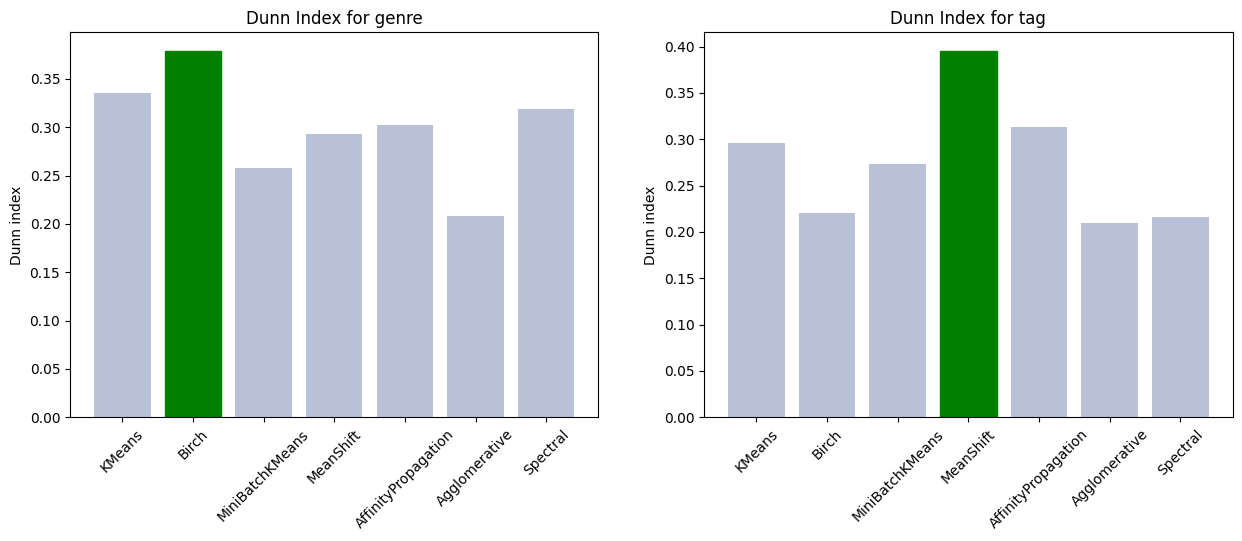

In [205]:
#plot the Dunn index for different clustering models
genre_Dunn = []
for i in range(len(genre_models)):
    genre_Dunn.append(calculate_Dunn_index(all_genre_ratings_train, genre_models[i]))
best_genre = genre_Dunn.index(max(genre_Dunn))

tag_Dunn = []
for i in range(len(tag_models)):
    tag_Dunn.append(calculate_Dunn_index(all_tags_ratings_train, tag_models[i]))
best_tag = tag_Dunn.index(max(tag_Dunn))

plot_results(model_names, genre_Dunn, tag_Dunn, [best_genre, best_tag], 'Dunn Index for', 'Dunn index')

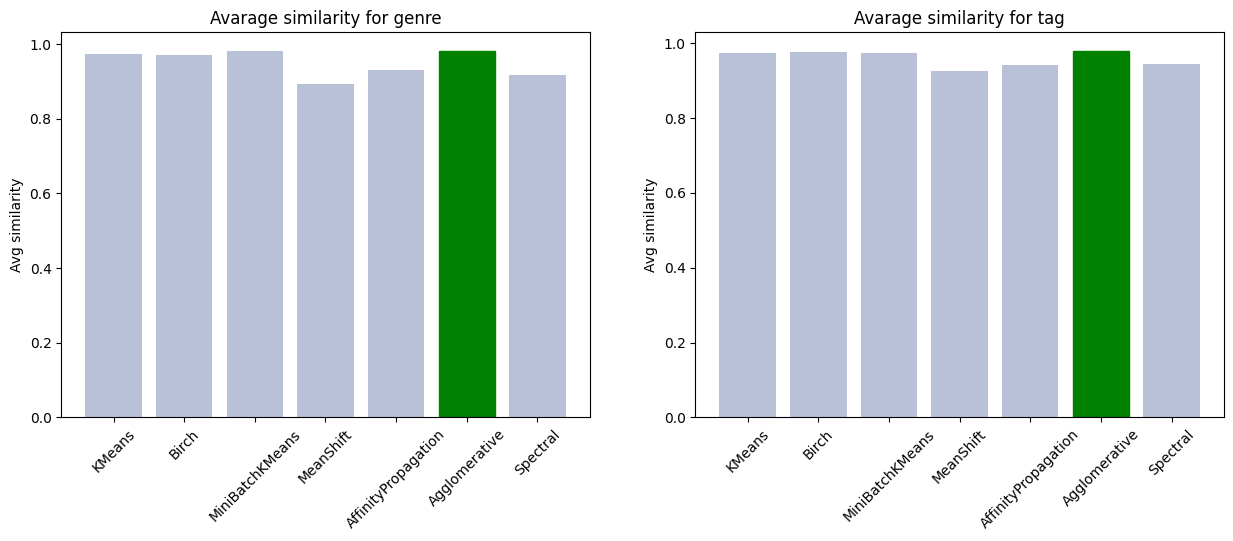

In [206]:
#plot the avarage similarity for different clustering models
genre_similarities = []
for i in range(len(genre_models)):
    genre_similarities.append(average_similarity(all_genre_ratings_train.drop('userId', axis=1).values, genre_models[i]))
best_genre = genre_similarities.index(max(genre_similarities))

tag_similarities = []
for i in range(len(tag_models)):
    tag_similarities.append(average_similarity(all_tags_ratings_train.drop('userId', axis= 1).values, tag_models[i]))
best_tag = tag_similarities.index(max(tag_similarities))

plot_results(model_names, genre_similarities, tag_similarities, [best_genre, best_tag], 'Avarage similarity for', 'Avg similarity')

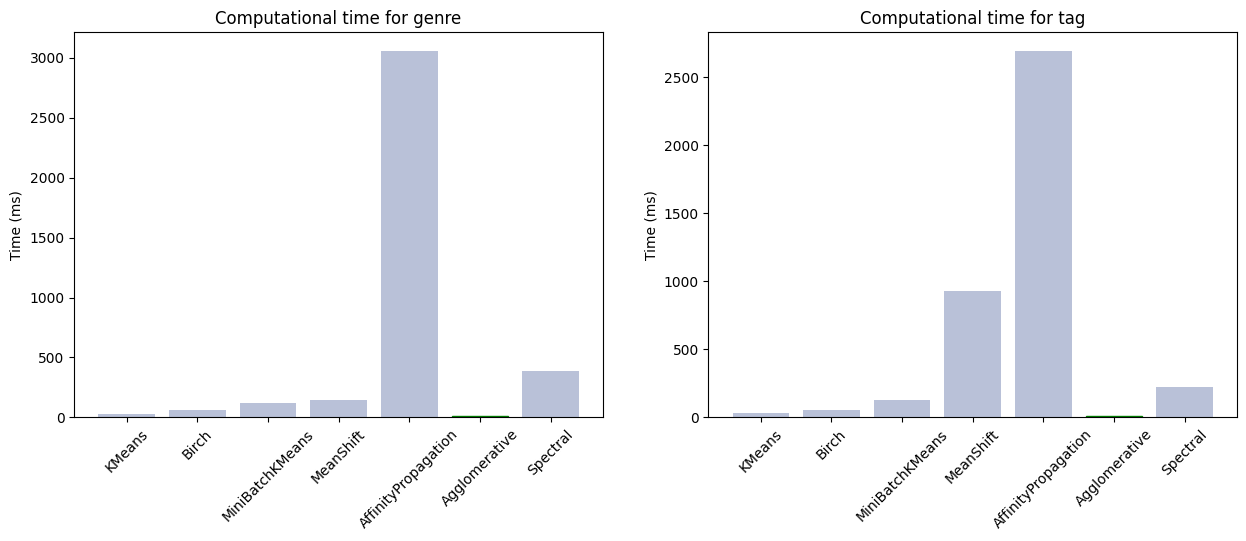

In [207]:

#plot the computational time for different clustering models
genre_results = evaluate_models(all_genre_ratings_train, clustering_methods)
best_genre = genre_results.index(min(genre_results))
tag_results = evaluate_models(all_tags_ratings_train, clustering_methods)
best_tag = tag_results.index(min(tag_results))

plot_results(model_names, genre_results, tag_results, [best_genre, best_tag], 'Computational time for', 'Time (ms)')

In [208]:
TOP_N_MOVIES_GENRE(all_genre_ratings_train, all_genre_ratings_test, genre_model_birch, 609, 20, 'birch')

,title
movieId,
7071,"Woman Under the Influence, A (1974)"
40491,"Match Factory Girl, The (Tulitikkutehtaan tytt..."
86237,Connections (1978)
72142,Love Exposure (Ai No Mukidashi) (2008)
26587,"Decalogue, The (Dekalog) (1989)"
72171,Black Dynamite (2009)
134796,Bitter Lake (2015)
27704,Battle Royale 2: Requiem (Batoru rowaiaru II: ...
163925,"Wings, Legs and Tails (1986)"


In [209]:
TOP_N_MOVIES_TAGS(all_tags_ratings_train, all_tags_ratings_test, tag_model_birch, 125, 20, 'birch')

,title
movieId,
3086,Babes in Toyland (1934)
7614,Oklahoma! (1955)
668,Song of the Little Road (Pather Panchali) (1955)
670,"World of Apu, The (Apur Sansar) (1959)"
2972,Red Sorghum (Hong gao liang) (1987)
114265,Laggies (2014)
3326,What Planet Are You From? (2000)
3637,Vagabond (Sans toit ni loi) (1985)
2969,"Man and a Woman, A (Un homme et une femme) (1966)"


My last strategy, will be to perform dimensionality reduction through the use of PRINCIPAL COMPONENT ANALYSIS (PCA) to extract the fundamental relations within the dataset features while reducing their magnitude.

In [210]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def Pca(data, threshold=0.9):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA()
    pca_data = pca.fit_transform(scaled_data)

    # Determine the number of components to explain 75% of the variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)
    n_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    # Transform data with the selected number of components
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)

    # Analyze the principal components
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=data.columns)

    #print(loadings_df)
    return reduced_data

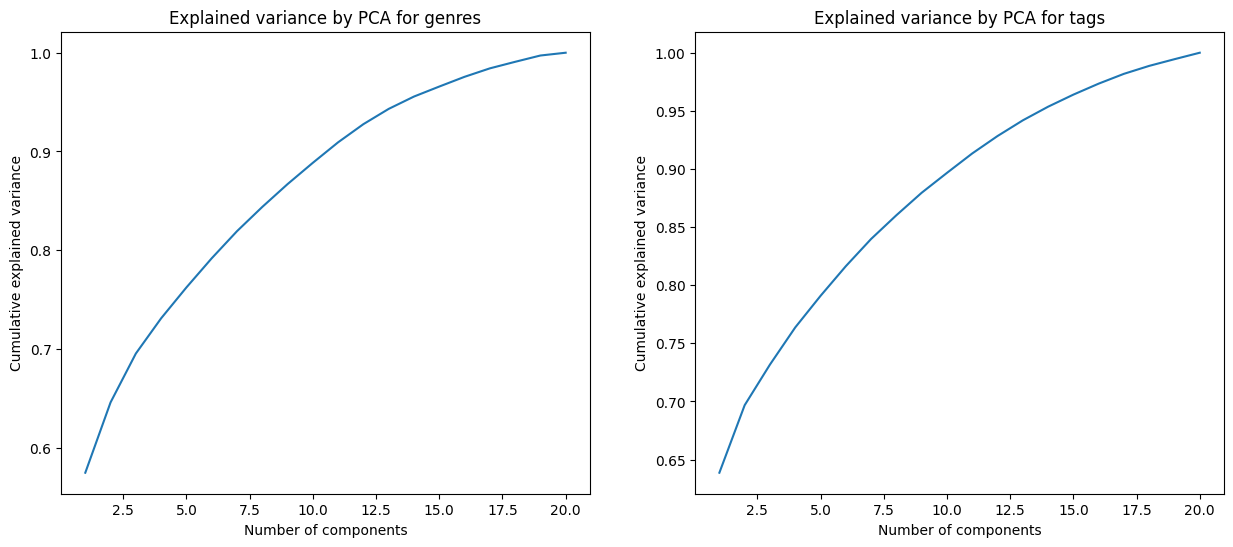

In [211]:
#plot the explained variance for the PCA
def plot_explained_variance(genre_data, tag_data):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(genre_data)

    pca = PCA()
    pca_data = pca.fit_transform(scaled_data)

    explained_variance_genre = pca.explained_variance_ratio_
    cumulative_explained_variance_genre = np.cumsum(explained_variance_genre)

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121)
    ax.plot(range(1, len(explained_variance_genre) + 1), cumulative_explained_variance_genre)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance')
    ax.set_title('Explained variance by PCA for genres')

    scaled_data = scaler.fit_transform(tag_data)

    pca2 = PCA()
    pca_data = pca2.fit_transform(scaled_data)

    explained_variance_tag = pca2.explained_variance_ratio_
    cumulative_explained_variance_tag = np.cumsum(explained_variance_tag)

    ax = fig.add_subplot(122)
    ax.plot(range(1, len(explained_variance_tag) + 1), cumulative_explained_variance_tag)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance')
    ax.set_title('Explained variance by PCA for tags')

#plot the explained variance for the PCA
plot_explained_variance(all_genre_ratings.drop('userId', axis=1), all_tags_ratings.drop('userId', axis=1))

Principal components analysis and visualization

Text(0.5, 1.0, 'PCA of Movie Tags Ratings')

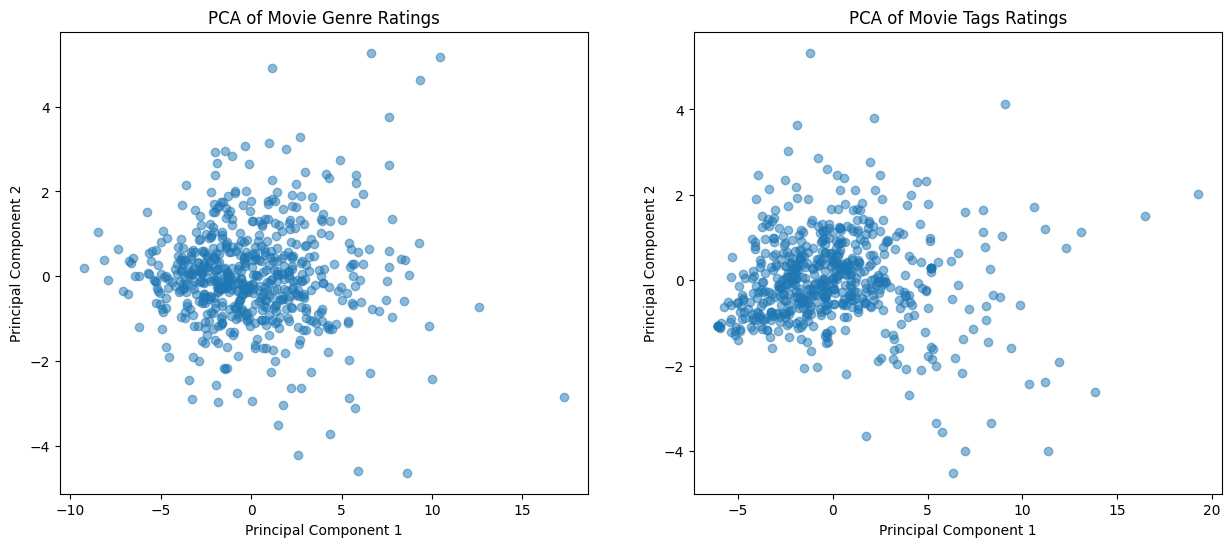

In [212]:
data1 = all_genre_ratings.copy()
genre_ids = data1['userId']
data1 = data1.drop('userId', axis=1)
genre_pca = Pca(data1)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(genre_pca[:, 0], genre_pca[:, 1], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Movie Genre Ratings')

data1 = all_tags_ratings.copy()
tag_ids = data1['userId']
data1 = data1.drop('userId', axis=1)
tag_pca = Pca(data1)

ax = fig.add_subplot(122)
ax.scatter(tag_pca[:, 0], tag_pca[:, 1], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Movie Tags Ratings')

In [217]:
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']
genre_pca = pd.concat([pd.DataFrame(genre_ids), pd.DataFrame(genre_pca, columns=columns)], axis=1)
tag_pca = pd.concat([pd.DataFrame(tag_ids), pd.DataFrame(tag_pca, columns=columns)], axis=1)
genre_pca = genre_pca.dropna()
tag_pca = tag_pca.dropna()

Training and test set separation

In [218]:
#divide the data into training and test set by 80% and 20% respectively
genre_pca_train = genre_pca.sample(frac=0.8, random_state=0)
genre_pca_test = genre_pca.drop(genre_pca_train.index)

tag_pca_train = tag_pca.sample(frac=0.8, random_state=0)
tag_pca_test = tag_pca.drop(tag_pca_train.index)

Clustering dataset with 7 algorithms

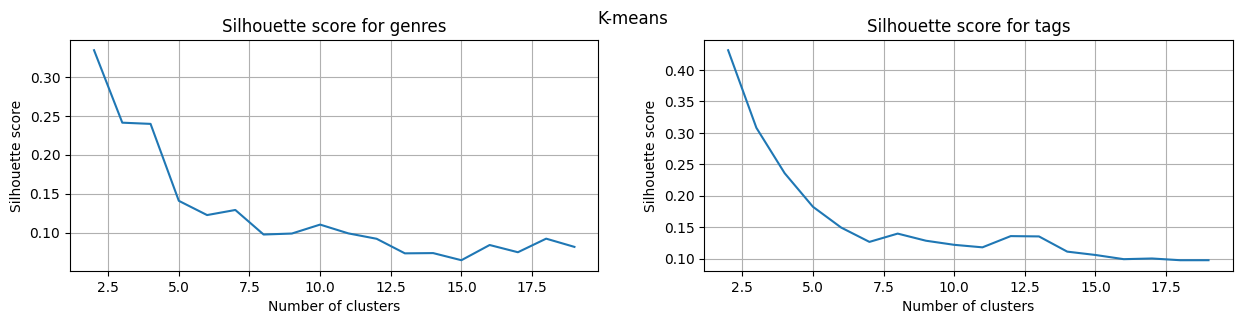

In [219]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], KMeans,'K-means')

#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(genre_pca_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(tag_pca_train, tag_K, KMeans)

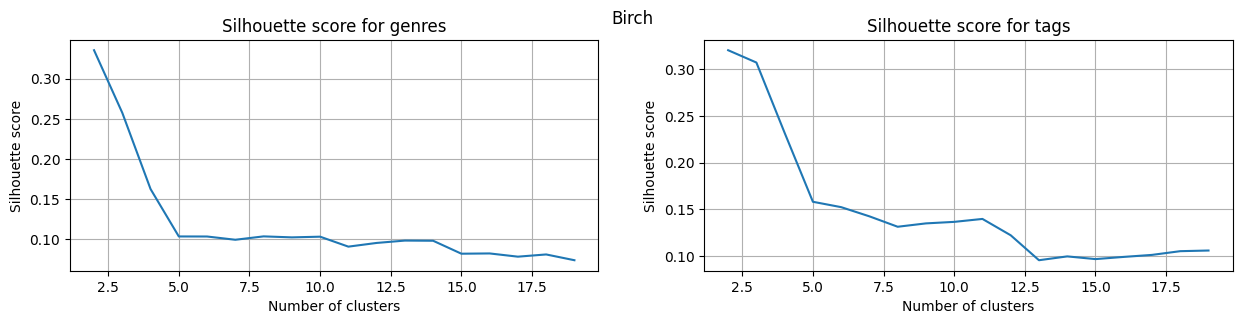

In [220]:
#optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], Birch,'Birch')

#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(genre_pca_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(tag_pca_train, tag_K, Birch)

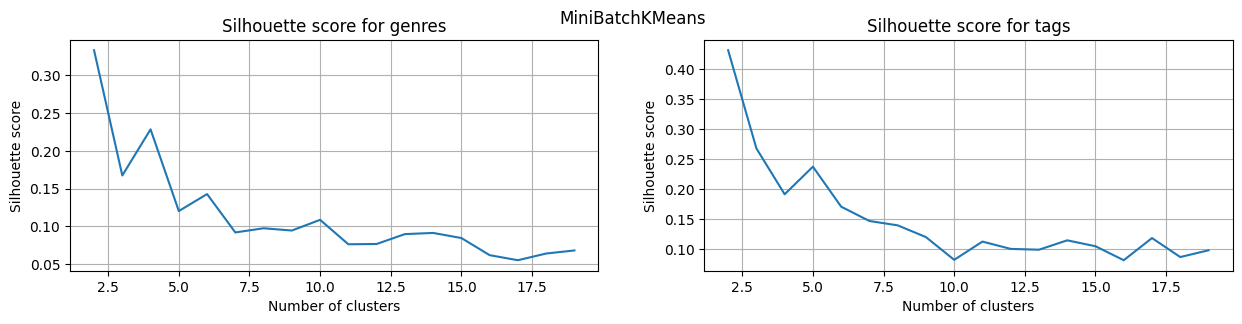

In [221]:
#optimization of K for MiniBatchKMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], MiniBatchKMeans,'MiniBatchKMeans')

#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(genre_pca_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(tag_pca_train, tag_K, MiniBatchKMeans)

In [222]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(genre_pca_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(tag_pca_train, 3, MeanShift)

In [223]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(genre_pca_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(tag_pca_train, 7, AffinityPropagation)

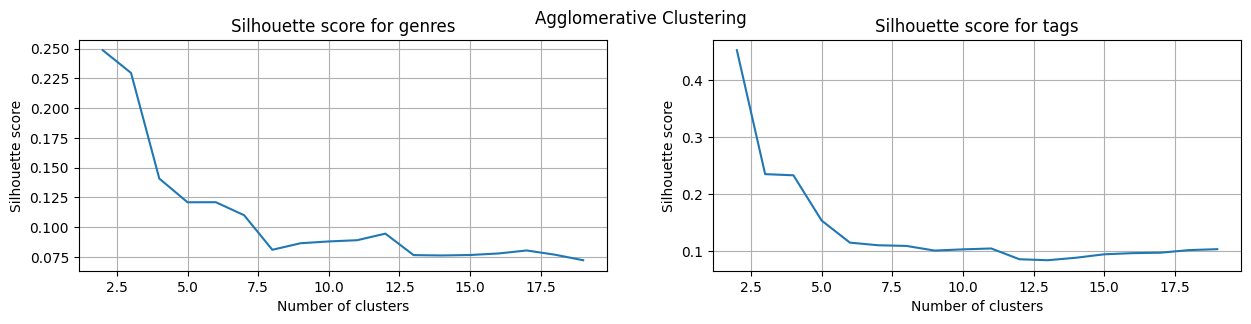

In [224]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], AgglomerativeClustering,'Agglomerative Clustering')

#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(genre_pca_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(tag_pca_train, tag_K, AgglomerativeClustering)

In [225]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(genre_pca_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(tag_pca_train, 3, SpectralClustering)

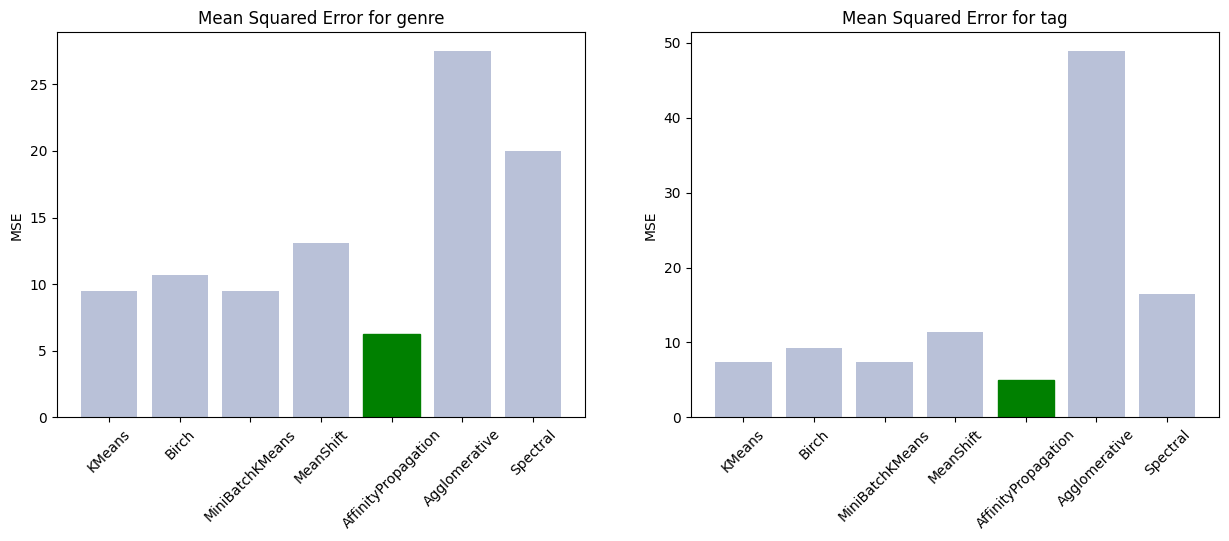

In [226]:
#plot the MSE for different clustering models
genre_models = [genre_model_kmean, genre_model_birch, genre_model_minibatcheskmeans, genre_model_meanshift, genre_model_affinity, genre_model_agglomerative, genre_model_spectral]
tag_models = [tag_model_kmean, tag_model_birch, tag_model_minibatcheskmeans, tag_model_meanshift, tag_model_affinity, tag_model_agglomerative, tag_model_spectral]
model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

genre_MSE = []
for i in range(len(genre_models)):
    genre_MSE.append(calculate_MSE(genre_pca_test, genre_models[i], genre_pca_train, model_names[i]))
best_genre = genre_MSE.index(min(genre_MSE))
                             
tag_MSE = []
for i in range(len(tag_models)):
    tag_MSE.append(calculate_MSE(tag_pca_test, tag_models[i], tag_pca_train, model_names[i]))
best_tag = tag_MSE.index(min(tag_MSE))

plot_results(model_names, genre_MSE, tag_MSE, [best_genre, best_tag], 'Mean Squared Error for', 'MSE')

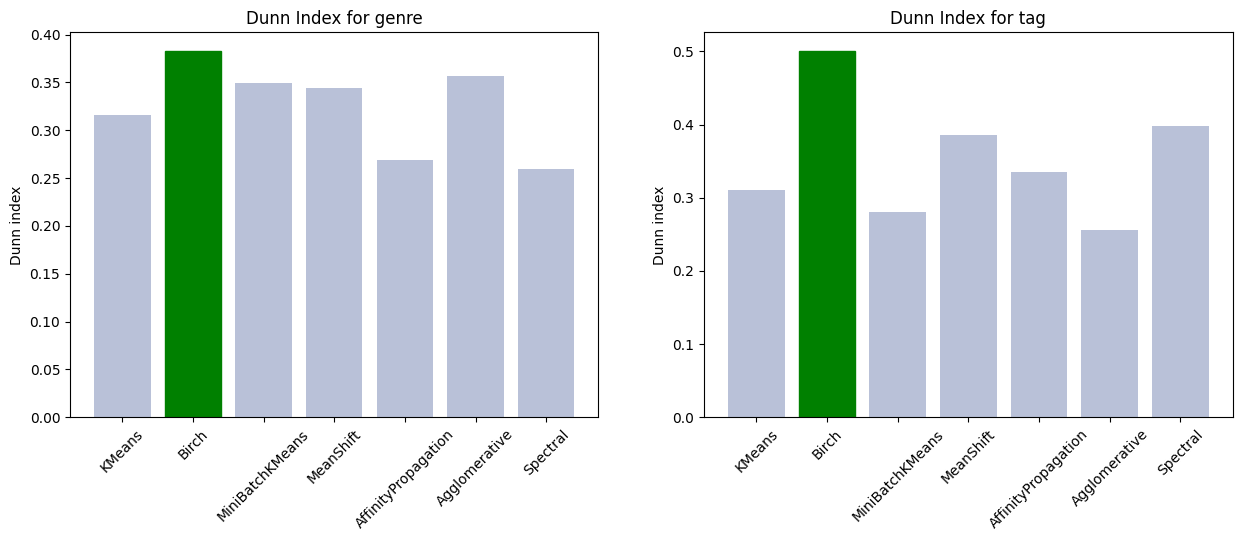

In [227]:

#plot the Dunn index for different clustering models
genre_Dunn = []

for i in range(len(genre_models)):
    genre_Dunn.append(calculate_Dunn_index(genre_pca_train, genre_models[i]))
best_genre = genre_Dunn.index(max(genre_Dunn))

tag_Dunn = []
for i in range(len(tag_models)):
    tag_Dunn.append(calculate_Dunn_index(tag_pca_train, tag_models[i]))
best_tag = tag_Dunn.index(max(tag_Dunn))

plot_results(model_names, genre_Dunn, tag_Dunn, [best_genre, best_tag], 'Dunn Index for', 'Dunn index')

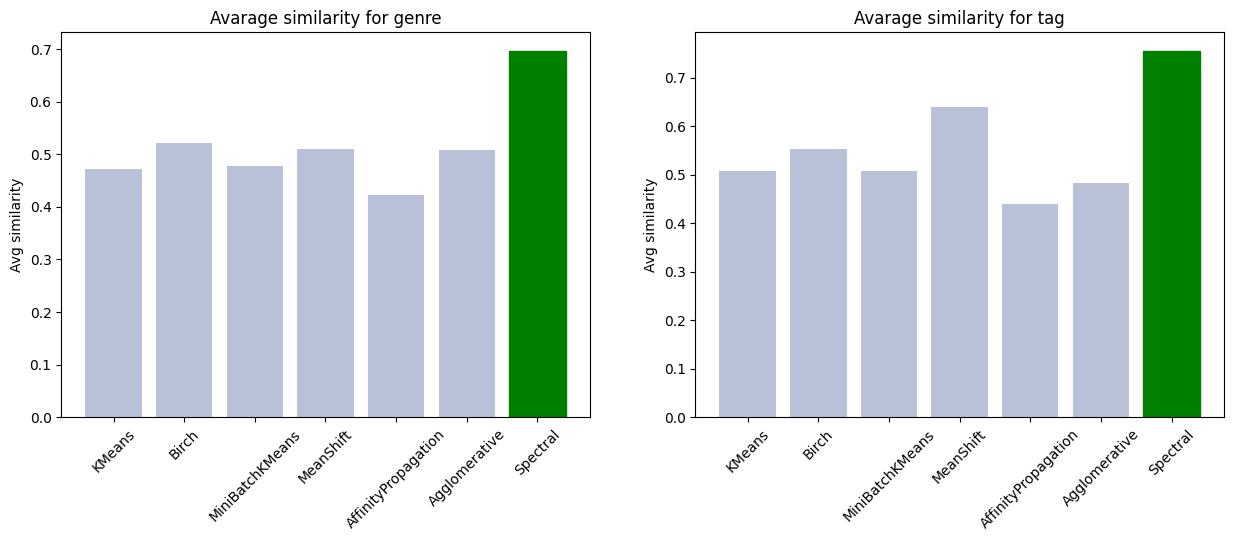

In [228]:
#plot the avarage similarity for different clustering models
genre_similarities = []
for i in range(len(genre_models)):
    genre_similarities.append(average_similarity(genre_pca_train.drop('userId', axis=1).values, genre_models[i]))
best_genre = genre_similarities.index(max(genre_similarities))

tag_similarities = []
for i in range(len(tag_models)):
    tag_similarities.append(average_similarity(tag_pca_train.drop('userId', axis=1).values, tag_models[i]))
best_tag = tag_similarities.index(max(tag_similarities))

plot_results(model_names, genre_similarities, tag_similarities, [best_genre, best_tag], 'Avarage similarity for', 'Avg similarity')

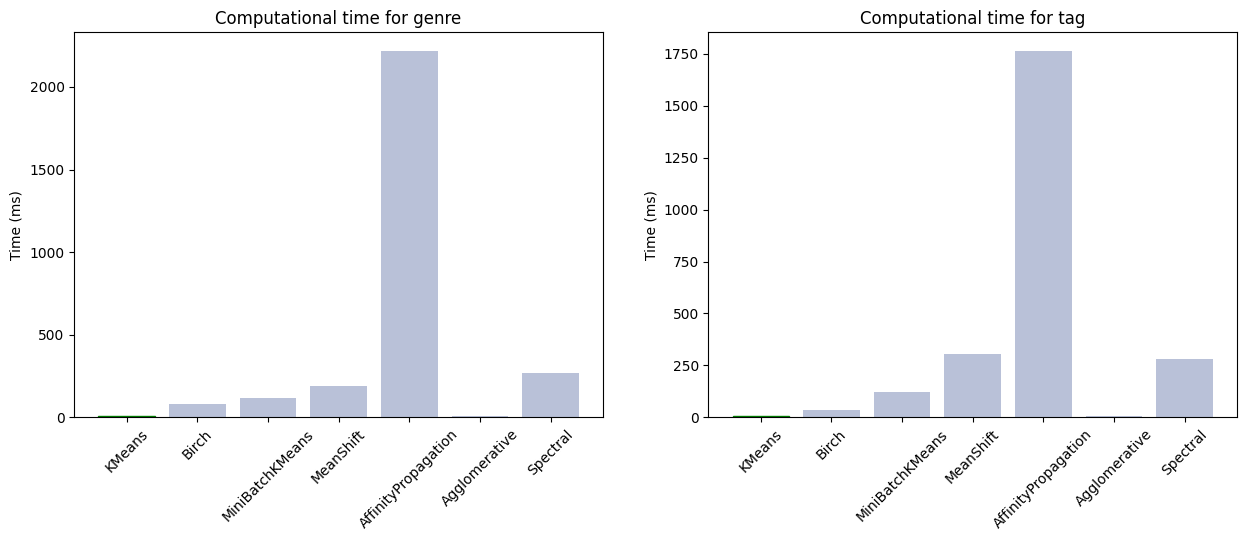

In [229]:
#plot the computational time for different clustering models
genre_results = evaluate_models(genre_pca_train, clustering_methods)
best_genre = genre_results.index(min(genre_results))
tag_results = evaluate_models(tag_pca_train, clustering_methods)
best_tag = tag_results.index(min(tag_results))

plot_results(model_names, genre_results, tag_results, [best_genre, best_tag], 'Computational time for', 'Time (ms)')

In [230]:
TOP_N_MOVIES_GENRE(genre_pca_train, genre_pca_test, genre_model_birch, 609, 20, 'birch')

,title
movieId,
4021,Before Night Falls (2000)
5328,Rain (2001)
5404,84 Charing Cross Road (1987)
6945,My Architect: A Son's Journey (2003)
1310,Hype! (1996)
1904,Henry Fool (1997)
116897,Wild Tales (2014)
3224,Woman in the Dunes (Suna no onna) (1964)
3223,"Zed & Two Noughts, A (1985)"


In [231]:
TOP_N_MOVIES_TAGS(tag_pca_train, tag_pca_test, tag_model_birch, 125, 20, 'birch')

,title
movieId,
48342,Conversations with Other Women (2005)
3836,Kelly's Heroes (1970)
131237,What Men Talk About (2010)
304,Roommates (1995)
131724,The Jinx: The Life and Deaths of Robert Durst ...
2206,Suspicion (1941)
893,Mother Night (1996)
6818,Come and See (Idi i smotri) (1985)
906,Gaslight (1944)


In [ ]:
#TODO implement the other evaluation metrics: 
#                1)metrics that are independent from the number of features 
#                2)indexes
#                3)social analysis/smt to evaluate the recommendations
#comparision between the different approaches
#clean code/move functions to a different file
#add comments
#presentation!